In [2]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [174]:
class K_MEANS:
    '''
    Divides given data into K clusters.
    
    Fields:
        df: Dataset without 'target' attribute
        N: Size of dataset
        k: Number of clusters
        MAX_ITER: Number of iterations
        labels: Class of each sample
        centroids: N x 2 array with coordinates of centroids
        distances: N x N matrix of distances, where len(df) = N
    '''
    
    def __init__(self, data, k = 3, MAX_ITER = 100):
        self.df = np.array(data)
        (self.N, self.M) = self.df.shape
        self.k = k;
        self.MAX_ITER = MAX_ITER
        self.iterations = 0
        self.labels = np.zeros(self.N, dtype=np.int)
        self.centroids = self.random_centroids()
        self.distances = self.compute_distances()
       
        
    def random_centroids(self):
        '''
        Returns:
            List of random k indices
        '''
        centrs = random.sample(range(self.N), self.k)
        return self.df[centrs]
    
    
    def compute_distances(self):
        '''
        Returns: 
            N x N matrix of distances
        '''
        X, Y = self.df, self.centroids
        dists = -2 * np.dot(X, Y.T) + np.sum(Y ** 2, axis=1)
        return dists
        
    
    def assign_centroids(self):
        '''
        Find closest centroid for each data sample
        
        Returns:
            True: Found new centroids
            False: Centroids are the same
        '''
        self.distances = self.compute_distances()
        nearest_centroids = np.argmin(self.distances, axis=1)
        
        if abs(np.sum(nearest_centroids - self.labels)) < 1e-100:
            return False
        
        self.labels = nearest_centroids
        return True
    
    
    def update_centroids(self):
        '''
        Determine new centroids by taking the average of all the points assigned to that cluster.
        '''
        new_centroids = np.zeros(self.k * self.M).reshape(self.k, self.M)
        centroid_cnt = np.full(self.k, 1e-100)
        for i in range(self.k):
            assigned_to_ith = self.labels == i
            new_centroids[i] += np.sum(self.df[assigned_to_ith], axis=0)
            centroid_cnt[i] += len(self.df[assigned_to_ith])
            
        self.centroids = new_centroids / centroid_cnt[:, np.newaxis]
        
    
    def RUN(self, show_images=False):
        '''
        Runs KMEANS algorithms as long as we can update centroids or till we reach MAX_ITER
        
        Parameters:
            show_images: True / False - either shows or does not show images
                         For a integer 'i' shows every ith image 
        '''
        for no in range(self.MAX_ITER):
            self.iterations = no
            if not self.assign_centroids():
                if show_images:
                    self.plot_2d()
                break
            
            if show_images and no % show_images == 0:
                self.plot_2d()
                
            self.update_centroids()
    
    def plot_2d(self):
        plt.figure(dpi=100)
        plt.title(f'Iterations: {self.iterations}')
        plt.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        plt.show()
        
        
    def plot_before_and_after_2d(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20,5)
        ax1.scatter(self.df[:, 0], self.df[:, 1], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), edgecolor='red', s=100, alpha=0.8)
        
        
    def plot_before_and_after_3d(self):
        fig = plt.figure(figsize=(20, 8))
        # 121 - 1 x 2 grid 1st subplot
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:, 2],  c=range(self.k), edgecolor='red', s=100, alpha=0.8)
    

# Zadanie 1. (1 punkt)
Napisz program, który generuje zbiór N = 5000 losowych wektorów danych z mieszaniny </br>
rozkładów gaussowskich o niżej podanych parametrach i sprawdź działanie algorytmu K-Means na tym zbiorze. </br>
**a) d = 2, K = 5, p = 1/K * 1, µk = 3k * 1, Σk = I (dla k = 1, 2, …, K), </br>
b) jak w a), oprócz Σ3 = [3 0; 0 1], </br>
c) jak w b), oprócz Σ1 = [3 1; 1 1], </br>
d) jak w c), oprócz p = [0.2; 0.1; 0.3; 0.1; 0.3], </br>
e) jak w a), oprócz d = 3 i Σ3 = [3 1 0; 1 1 0; 0 0 1], </br>
f) jak w a), oprócz d = 100 i K = 10.** </br>
(1 to wektor odpowiedniej długości złożony z samych jedynek, I to macierz identycznościowa). </br>
Jak pogrupowałbyś te dane, jeśli nie znałbyś wartości K użytej w generatorze?  </br>


In [177]:
def generate(N, d, K, p_vec, Mu, Sigma):
    '''
    Generates 'N' vectors of size 'd' from N(mu_i, sigma_i).
    
    Parameters:
        N: Number of vectors
        K: Number or d-dimensionals Gaussian distributions
        d: Dimensions
        p_vec: Vector of p_i: p_i, where p_i is pbb. of chosing ith distribution
        Mu: Vector of mu_i, where mu_i belongs to ith distribution
        Sigma: Vector of matrices Σ_i 
        
    Returns:
        Result: N x d matrix and targets
    '''
    
    assert((np.sum(p_vec) - 1) < 1e-10)
    assert(len(p_vec) == K and len(Mu) == K)
    
    distributions = [(Mu[i], Sigma[i]) for i in range(K)] 
 
    # Draw N distributions with pbbs
    distributions_ids = np.random.choice(range(K), N, list(p_vec))
 
    # Sample N vectors
    # We could use 'np.random.multivariate_normal(mean, cov, N).T'
    # But let's do a Cholesky decomposition
    
    Result = np.random.randn(N, d)
    Result = np.ones(N * d).reshape(N, d)
    L = np.linalg.cholesky(Sigma)
    
    for i in tqdm.tqdm(range(N)):
        Result[i, :] = Mu[distributions_ids[i], :] + np.dot(L[distributions_ids[i], :, :], Result[i, :])
    

    return np.array(Result)
        

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 357820.81it/s]


Iterations: 16


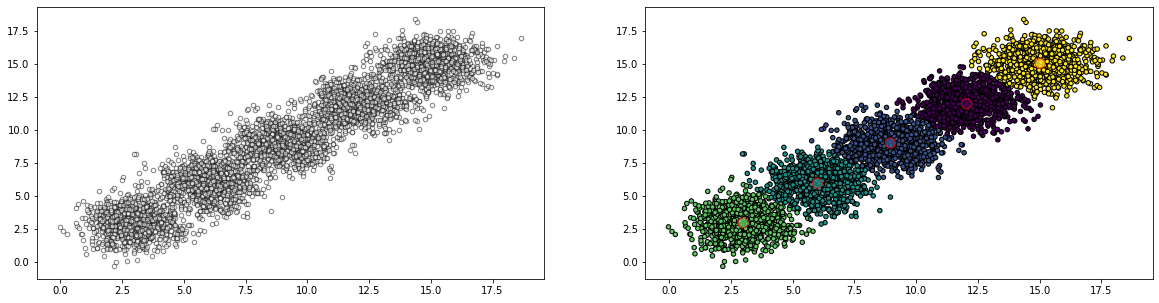

In [182]:
# a)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 358138.57it/s]


Iterations: 16


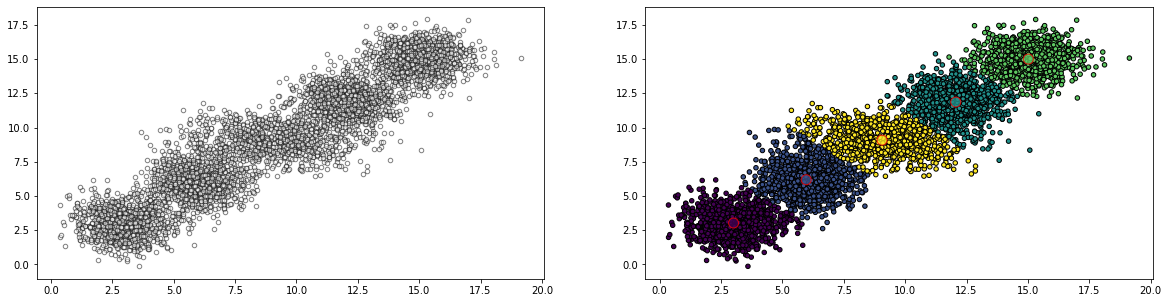

In [183]:
# b)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[2] = np.array([[3, 0], [0, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 49137.11it/s]


Iterations: 11


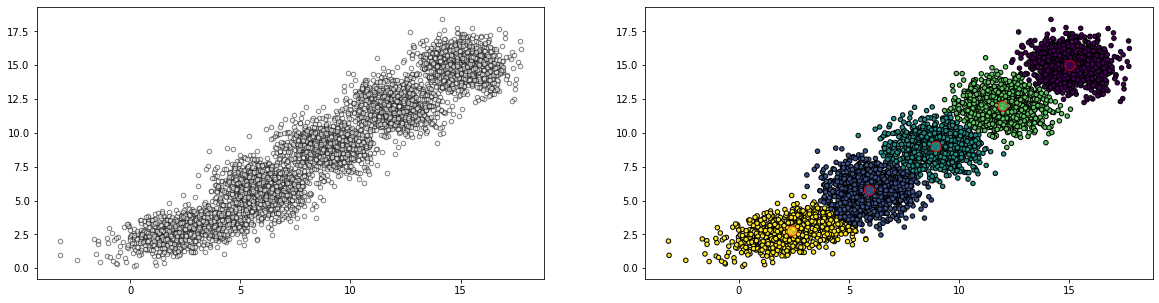

In [9]:
# c)
N, d, K = 5000, 2, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[0] = np.array([[3, 1], [1, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

Iterations: 6


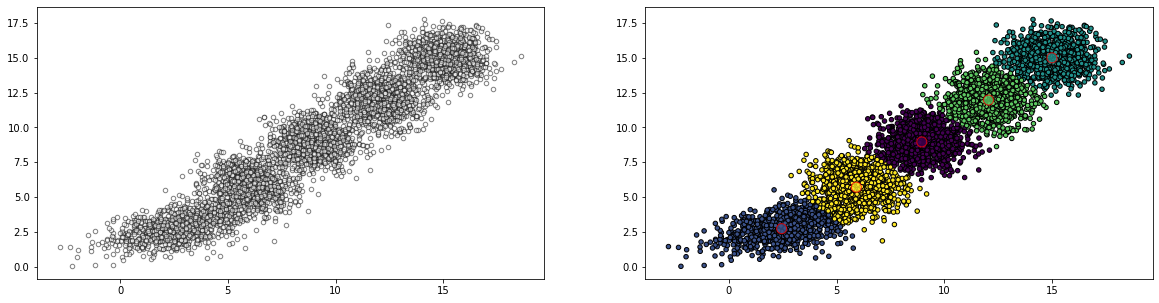

In [7]:
# d
N, d, K = 5000, 2, 5
p_vec = np.array([0.2, 0.1, 0.3, 0.1, 0.3])
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[0] = np.array([[3, 1], [1, 1]])
L = np.linalg.cholesky(Sigma[2])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
print(f'Iterations: {KM.iterations}')

Iterations: 14
Wall time: 146 ms


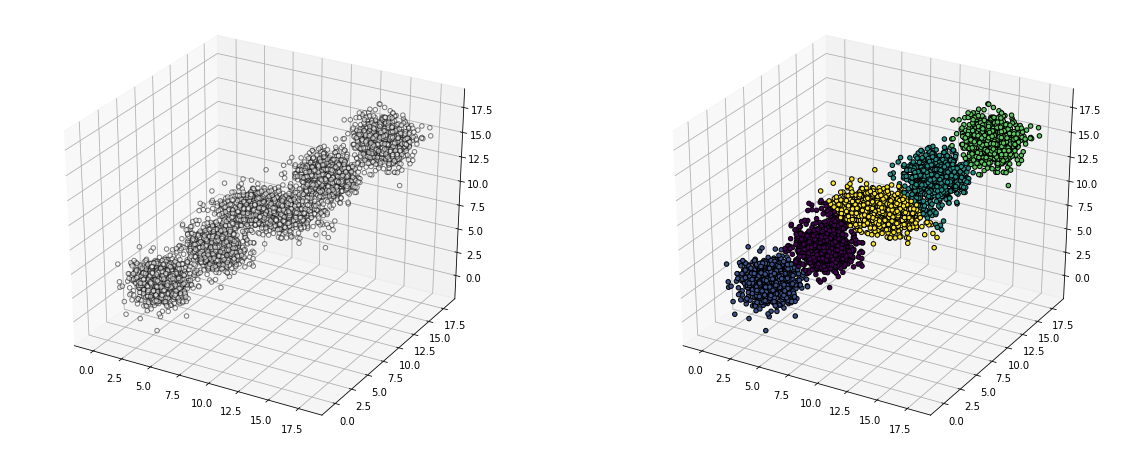

In [8]:
%%time
# e)
N, d, K = 5000, 3, 5
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)
Sigma[2] = np.array([[3, 1, 0], [1, 1, 0], [0, 0, 1]])

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=100)
KM.RUN(show_images=False)
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

100%|███████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 26039.80it/s]


Iterations: 6
Wall time: 296 ms


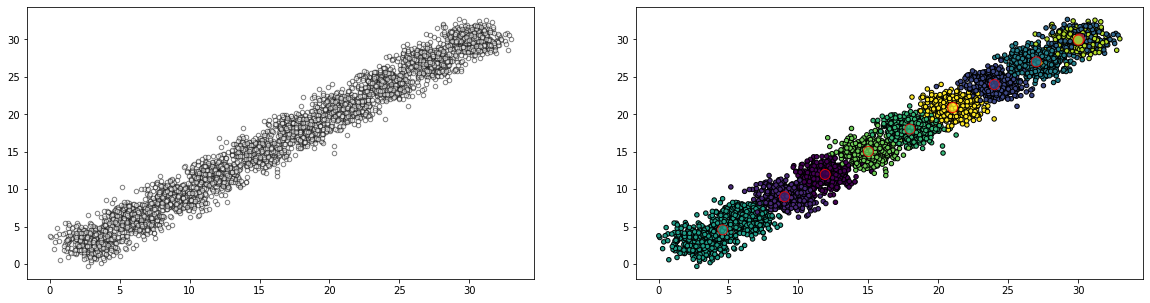

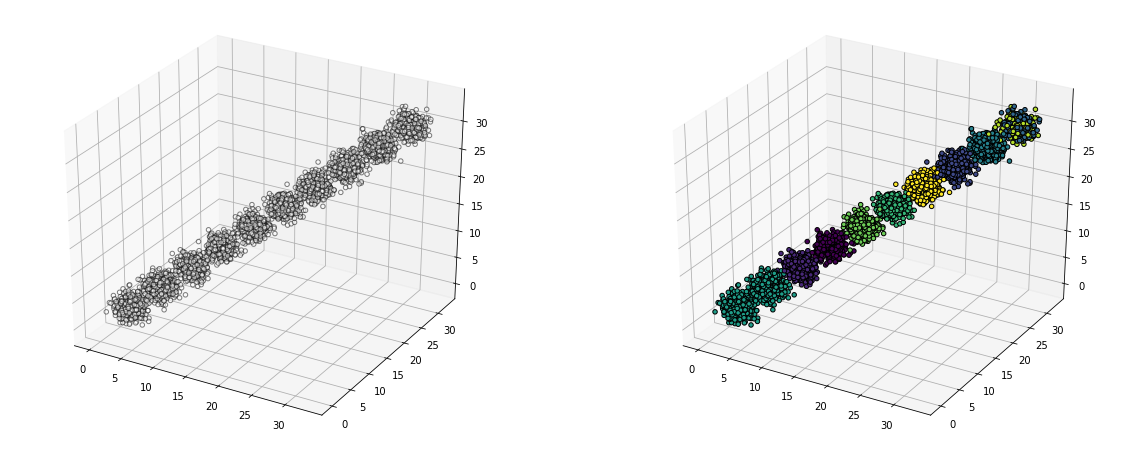

In [184]:
%%time
# f)
N, d, K = 5000, 100, 10
p_vec = np.ones(K) / K
Mu = 3 * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=200)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')

# Zadanie 2. (1 punkt)
Wygeneruj zbiór N = 1000000 losowych danych z d = 1000 wymiarowej mieszaniny K = 1000 <br/>
rozkładów gaussowskich takiej, że odległość między środkami µk każdych dwóch rozkładów tej <br/>
mieszaniny jest nie mniejsza niż q = 10. Prawdopodobieństwa wyboru rozkładów mogą być równe, <br/>
p = 1/K * 1, a same rozkłady mogą mieć nieskorelowane zmienne, Σk = I. Sprawdź działanie <br/>
algorytmu K-Means na tym zbiorze. Poeksperymentuj z innymi wartościami parametru q. <br/>


100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 26120.92it/s]


Iterations: 13
Wall time: 30.2 s


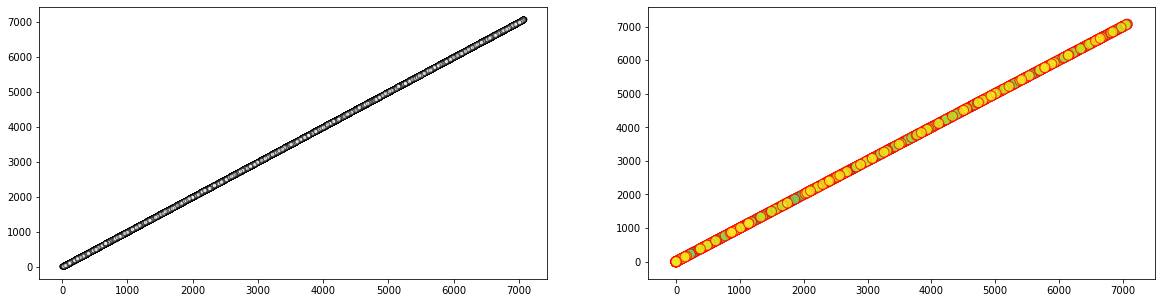

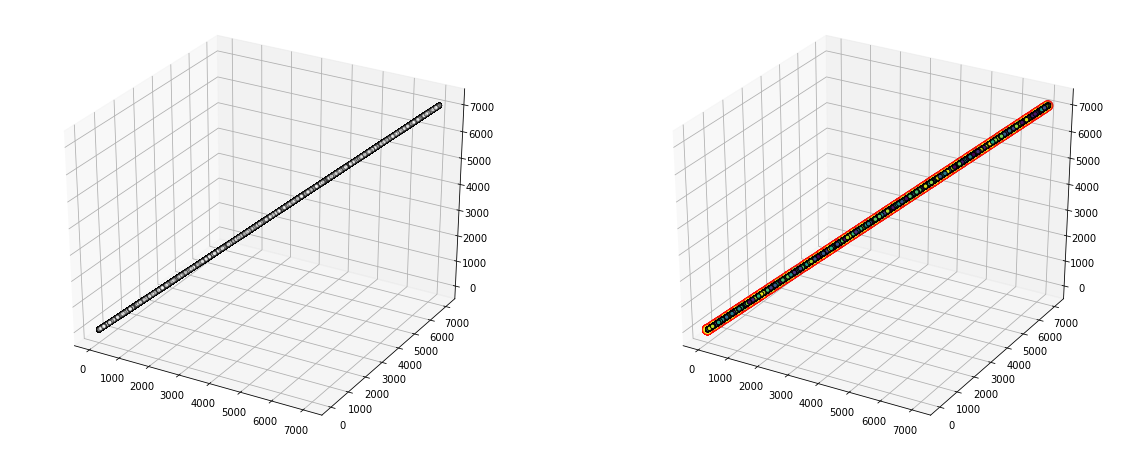

In [192]:
%%time
N, d, K = 100000, 100, 1000
p_vec = np.ones(K) / K
q = 10
dist = q / np.sqrt(2)
Mu = dist * np.ones([1, d]) * np.arange(1, K + 1)[:, np.newaxis]
Sigma = np.array([np.eye(d)] * K)

X = generate(N, d, K, p_vec, Mu, Sigma)
KM = K_MEANS(X, k=K, MAX_ITER=200)
KM.RUN(show_images=False)
KM.plot_before_and_after_2d()
KM.plot_before_and_after_3d()
print(f'Iterations: {KM.iterations}')